# CNNs with LSTMs 

## Imports

In [132]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Utilities

In [133]:
def plot_graph(x, y, no_fit=False):
    plt.plot(x, y, 'b')

    if no_fit == False:
        fit = linregress(x, y)
        fit_line = fit.slope * x + fit.intercept
        plt.plot(x, fit_line, 'r', linestyle='--')

    plt.ylabel('Graph')
    plt.xlabel('Time')
    plt.grid(True)
    plt.legend(['Graph', 'Fit(Trend)'])
    plt.show()

def multi_plot_graph(x, ys):
    for y in ys:
        plt.plot(x, y)

    plt.grid(True)
    plt.show()

In [134]:
def Trend(time, slope):
    return time * slope

def Seasonality(time, period):
    time = (time % period) / period
    return np.where(time < 0.5, np.cos(2 * np.pi * time), 1 / np.exp(5 * time))

def Noise(time, amplitude):
    return amplitude * np.random.randn(len(time))

## Dataset Generation

In [135]:
t = np.arange(0, 4 * 365 + 1, 1)
signal = Trend(t, 0.05) + 20 * Seasonality(t, 365) + Noise(t, 2)

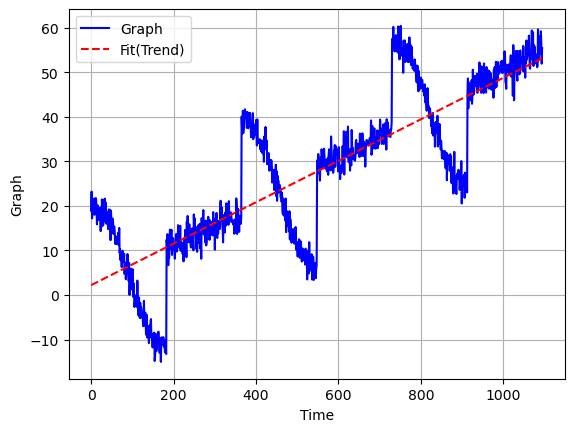

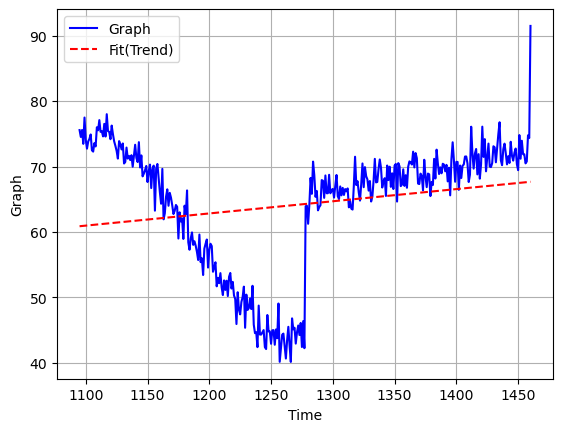

In [136]:
SPLIT_TIME = 3 * 365
t_data = signal[:SPLIT_TIME]
t_time = t[:SPLIT_TIME]
v_data = signal[SPLIT_TIME:]
v_time = t[SPLIT_TIME:]

plot_graph(t_time, t_data)
plot_graph(v_time, v_data)

In [137]:
WINDOW_SIZE = 20
BATCH_SIZE = 16

In [138]:
def create_dataset(series, w_size, no_labels=False):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=w_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(w_size))

    if no_labels == False:
        dataset = dataset.map(lambda x: (x[:-1], x[-1]))
        dataset = dataset.shuffle(len(series))
        
    dataset = dataset.batch(BATCH_SIZE).prefetch(2)
    return dataset


In [139]:
train_set = create_dataset(t_data, WINDOW_SIZE+1)
val_set = create_dataset(v_data, WINDOW_SIZE)

## Model Creation

In [140]:
NUM_FILTERS = 32
LSTM_UNITS = 16
KERNEL_SIZE = 3
EPOCHS = 500

In [141]:
from tensorflow.keras.layers import Dense, Conv1D, Bidirectional, LSTM, Lambda
tf.keras.backend.clear_session()

def create_model():
    return tf.keras.Sequential([
        Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', input_shape=(None, 1)),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)), 
        Bidirectional(LSTM(LSTM_UNITS)),
        Dense(1),
        Lambda(lambda y: y * 400)
    ])

In [142]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          128       
                                                                 
 bidirectional (Bidirection  (None, None, 32)          6272      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (

In [143]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import LearningRateScheduler

lr_scheduler = LearningRateScheduler(lambda e: 1e-8 * 10 ** (e / 100))

model.compile(
    optimizer=SGD(momentum=0.9),
    loss=Huber()
)

## Model Training

In [144]:
hist = model.fit(train_set, epochs=EPOCHS, callbacks=[lr_scheduler])

Epoch 1/500


68/68 [==============================] - 3s 6ms/step - loss: 126.0850 - lr: 1.0000e-08
Epoch 2/500
68/68 [==============================] - 0s 5ms/step - loss: 30.6392 - lr: 1.0233e-08
Epoch 3/500
68/68 [==============================] - 0s 5ms/step - loss: 15.8447 - lr: 1.0471e-08
Epoch 4/500
68/68 [==============================] - 0s 6ms/step - loss: 14.7846 - lr: 1.0715e-08
Epoch 5/500
68/68 [==============================] - 0s 5ms/step - loss: 13.7545 - lr: 1.0965e-08
Epoch 6/500
68/68 [==============================] - 0s 5ms/step - loss: 12.8747 - lr: 1.1220e-08
Epoch 7/500
68/68 [==============================] - 0s 5ms/step - loss: 12.1349 - lr: 1.1482e-08
Epoch 8/500
68/68 [==============================] - 0s 5ms/step - loss: 11.5085 - lr: 1.1749e-08
Epoch 9/500
68/68 [==============================] - 0s 5ms/step - loss: 10.9901 - lr: 1.2023e-08
Epoch 10/500
68/68 [==============================] - 0s 5ms/step - loss: 10.4503 - lr: 1.2303e-08
Epoch 11/500
68/68 [==========

## Plotting metrics
### Loss vs Learning rate

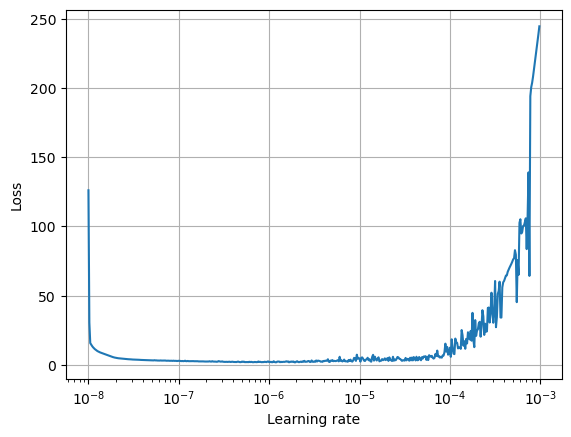

In [145]:
l_rates = 1e-8 * 10 ** (np.arange(EPOCHS) / 100)
plt.semilogx(l_rates, hist.history['loss'])
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [146]:
min_loss = np.min(hist.history['loss'])
best_epoch = np.argmin(hist.history['loss']) + 1
best_lr = hist.history['lr'][best_epoch - 1]
print('MINIMUM LOSS', min_loss)
print('BEST EPOCH', best_epoch)
print('BEST LR', best_lr)

MINIMUM LOSS 1.9508368968963623
BEST EPOCH 223
BEST LR 1.6595869e-06


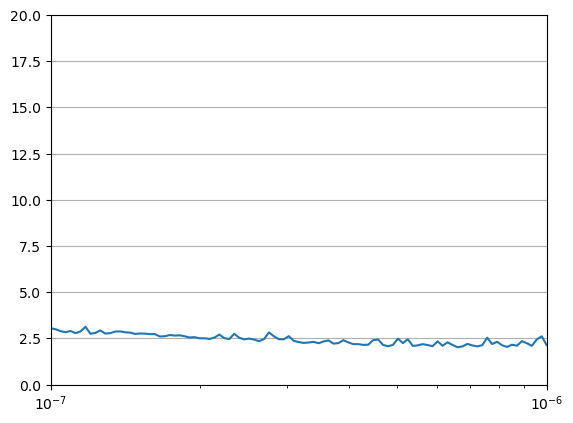

In [147]:
plt.semilogx(l_rates, hist.history['loss'])
plt.grid(True)
plt.axis([1e-7, 1e-6, 0, 20])
plt.show()

### Loss vs epochs

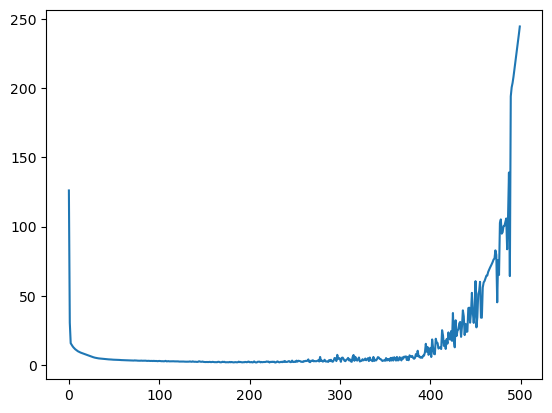

In [148]:
plt.plot(hist.history['loss'])
plt.show()

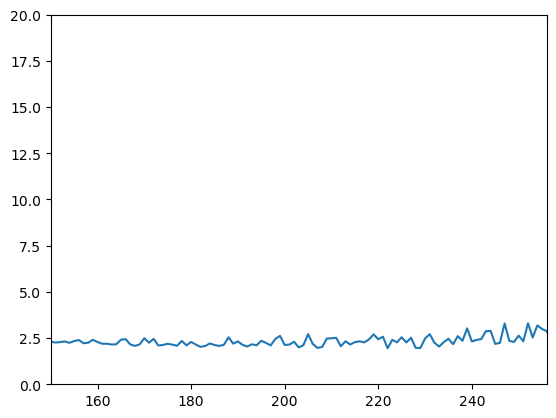

In [149]:
plt.plot(hist.history['loss'])
plt.axis([150, 256, 0, 20])
plt.show()

## Model Optimization

In [150]:
model2 = create_model()
model2.compile(
    optimizer=SGD(learning_rate=best_lr, momentum=0.9),
    loss=Huber(),
    metrics=['mae']
)

In [151]:
class custom_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs['val_mae'] < 4.5:
            self.model.stop_training = True
            print('\nStopping training')

optimal_training_callback = custom_callback()

In [152]:
hist2 = model2.fit(train_set, validation_data=val_set, epochs=EPOCHS, callbacks=[optimal_training_callback])

Epoch 1/500
68/68 [==============================] - 4s 17ms/step - loss: 18.8222 - mae: 19.3058 - val_loss: 8.6148 - val_mae: 9.1027
Epoch 2/500
68/68 [==============================] - 0s 6ms/step - loss: 8.2191 - mae: 8.6995 - val_loss: 5.9807 - val_mae: 6.4664
Epoch 3/500
68/68 [==============================] - 0s 6ms/step - loss: 6.2388 - mae: 6.7151 - val_loss: 6.4257 - val_mae: 6.9207
Epoch 4/500
68/68 [==============================] - 0s 6ms/step - loss: 5.3679 - mae: 5.8390 - val_loss: 10.3600 - val_mae: 10.8537
Epoch 5/500
68/68 [==============================] - 0s 6ms/step - loss: 4.7471 - mae: 5.2208 - val_loss: 6.2231 - val_mae: 6.7127
Epoch 6/500
68/68 [==============================] - 0s 6ms/step - loss: 4.3279 - mae: 4.7985 - val_loss: 5.8768 - val_mae: 6.3663
Epoch 7/500
68/68 [==============================] - 0s 6ms/step - loss: 3.9840 - mae: 4.4566 - val_loss: 7.0261 - val_mae: 7.5113
Epoch 8/500
68/68 [==============================] - 0s 6ms/step - loss: 3.801

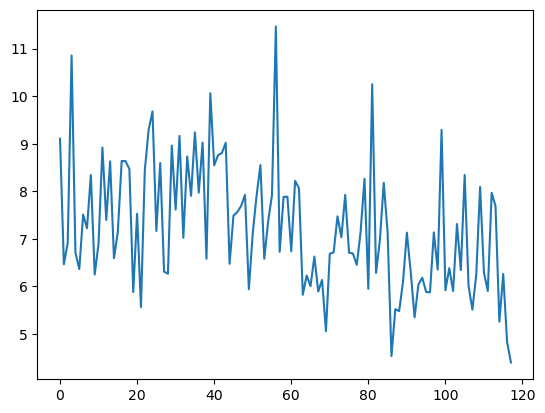

In [153]:
plt.plot(hist2.history['val_mae'])
plt.show()

In [154]:
forecast_series = signal[SPLIT_TIME-WINDOW_SIZE:-1]
forecast = create_dataset(forecast_series, WINDOW_SIZE, no_labels=True)
prediction = model2.predict(forecast)
prediction = prediction.squeeze()

23/23 [==============================] - 1s 2ms/step


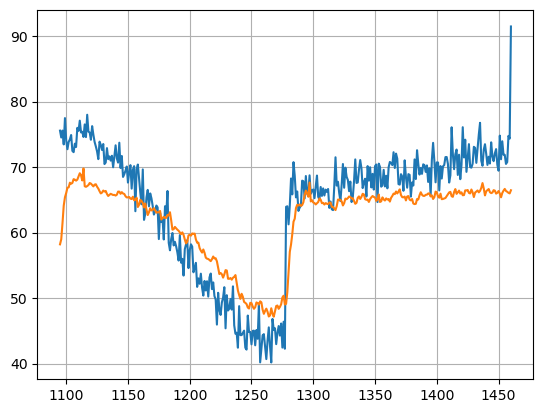

In [155]:
multi_plot_graph(v_time, (v_data, prediction))

In [156]:
print(tf.keras.metrics.mean_absolute_error(v_data, prediction).numpy())
print(tf.keras.metrics.mean_squared_error(v_data, prediction).numpy())

4.482128
28.84203
